In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 1000)
import datetime
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import time
import os
import copy

#### 定义获取数据函数

In [2]:
def fix_data(path):
    tmp = pd.read_csv(path, encoding="gbk", engine='python')
    tmp.rename(columns={'Unnamed: 0':'trading_time'}, inplace=True)
    tmp['trading_point'] = pd.to_datetime(tmp.trading_time)
    del tmp['trading_time']
    tmp.set_index(tmp.trading_point, inplace=True)
    return tmp

def High_2_Low(tmp, freq):
    """处理从RiceQuant下载的分钟线数据，
    从分钟线数据合成低频数据
    2017-08-11    
    """
    # 分别处理bar数据
    tmp_open = tmp['open'].resample(freq).ohlc()
    tmp_open = tmp_open['open'].dropna()

    tmp_high = tmp['high'].resample(freq).ohlc()
    tmp_high = tmp_high['high'].dropna()

    tmp_low = tmp['low'].resample(freq).ohlc()
    tmp_low = tmp_low['low'].dropna()

    tmp_close = tmp['close'].resample(freq).ohlc()
    tmp_close = tmp_close['close'].dropna()

    tmp_price = pd.concat([tmp_open, tmp_high, tmp_low, tmp_close], axis=1)
    
    # 处理成交量
    tmp_volume = tmp['volume'].resample(freq).sum()
    tmp_volume.dropna(inplace=True)
    
    return pd.concat([tmp_price, tmp_volume], axis=1)

#### 处理数据

In [3]:
from Talib_calc import *

tmp = fix_data('000001.XSHE.csv')
print(tmp.shape)


# targets 1d 数据合成
tmp_1d = High_2_Low(tmp, '1d')
rolling = 88
targets = tmp_1d
targets['returns'] =  targets['close'].shift(-2) / targets['close'] - 1.0
targets['upper_boundary']= targets.returns.rolling(rolling).mean() + 0.5 * targets.returns.rolling(rolling).std()
targets['lower_boundary']= targets.returns.rolling(rolling).mean() - 0.5 * targets.returns.rolling(rolling).std()
targets.dropna(inplace=True)
targets['labels'] = 1
targets.loc[targets['returns']>=targets['upper_boundary'], 'labels'] = 2
targets.loc[targets['returns']<=targets['lower_boundary'], 'labels'] = 0

print(targets.shape)


# factors 1d 数据合成
tmp_1d = High_2_Low(tmp, '1d')
Index = tmp_1d.index
High = tmp_1d.high.values
Low = tmp_1d.low.values
Close = tmp_1d.close.values
Open = tmp_1d.open.values
Volume = tmp_1d.volume.values
factors = get_factors(Index, Open, Close, High, Low, Volume, rolling = 26, drop=True)

factors = factors.loc[:targets.index[-1]]
print(factors.shape)


tmp_factors_1 = factors.iloc[:12]
targets = targets.loc[tmp_factors_1.index[-1]:]

gather_list = np.arange(factors.shape[0])[11:]
print(gather_list.shape)

(733, 6)
(644, 9)
(619, 58)
(608,)


#### 转换数据

In [4]:
inputs = np.array(factors).reshape(-1, 1, factors.shape[1])

def dense_to_one_hot(labels_dense):
    """标签 转换one hot 编码
    输入labels_dense 必须为非负数
    2016-11-21
    """
    num_classes = len(np.unique(labels_dense)) # np.unique 去掉重复函数
    raws_labels = labels_dense.shape[0]
    index_offset = np.arange(raws_labels) * num_classes
    labels_one_hot = np.zeros((raws_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot  

targets = dense_to_one_hot(targets['labels'])
targets = np.expand_dims(targets, axis=1)


print(inputs.shape)
print(targets.shape)
print(gather_list.shape)

(619, 1, 58)
(608, 1, 3)
(608,)


#### 训练模型

In [5]:
from Classifier_PonderDNC_BasicLSTM_L3 import *

op1 = Classifier_PonderDNC_BasicLSTM_L3(
    inputs= inputs, 
    targets= targets, 
    gather_list= gather_list, 
    hidden_size= 50, 
    memory_size= 50, 
    pondering_coefficient= 1e-2, 
    learning_rate= 1e-2)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [6]:
op1.fit(training_iters = 100,
        display_step = 10,
        save_path = "model/ResidualPonderDNC_1.ckpt")

0   loss-- 1.14579   acc-- 0.307566   pondering_cost-- 0.0270348   rnn_cost-- 1.11875   final_iteration 2.39742
10   loss-- 1.10145   acc-- 0.458882   pondering_cost-- 0.0270162   rnn_cost-- 1.07443   final_iteration 2.39257
20   loss-- 1.06162   acc-- 0.496711   pondering_cost-- 0.0270027   rnn_cost-- 1.03461   final_iteration 2.38772
30   loss-- 1.03301   acc-- 0.501645   pondering_cost-- 0.0269946   rnn_cost-- 1.00602   final_iteration 2.38449
40   loss-- 1.01218   acc-- 0.519737   pondering_cost-- 0.0269098   rnn_cost-- 0.985268   final_iteration 2.36995
50   loss-- 0.989137   acc-- 0.534539   pondering_cost-- 0.0268514   rnn_cost-- 0.962285   final_iteration 2.36349
60   loss-- 0.957962   acc-- 0.555921   pondering_cost-- 0.0268597   rnn_cost-- 0.931102   final_iteration 2.3651
70   loss-- 0.913325   acc-- 0.595395   pondering_cost-- 0.0272076   rnn_cost-- 0.886117   final_iteration 2.42003
80   loss-- 1.19734   acc-- 0.396382   pondering_cost-- 0.0283169   rnn_cost-- 1.16902   fi

In [7]:
#op1.close()

#### second

In [8]:
tf.reset_default_graph()
op2 = Classifier_PonderDNC_BasicLSTM_L3(
    inputs= inputs, 
    targets= targets, 
    gather_list= gather_list, 
    hidden_size= 50, 
    memory_size= 50, 
    pondering_coefficient= 1e-2, 
    learning_rate= 1e-3)

op2.fit(training_iters = 100,
        display_step = 10,
        save_path = "model/ResidualPonderDNC_1.ckpt",
        restore_path = "model/ResidualPonderDNC_1.ckpt")

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from model/ResidualPonderDNC_1.ckpt
0   loss-- 0.864321   acc-- 0.629934   pondering_cost-- 0.0284904   rnn_cost-- 0.835831   final_iteration 2.59612
10   loss-- 0.826218   acc-- 0.667763   pondering_cost-- 0.0286871   rnn_cost-- 0.797531   final_iteration 2.61228
20   loss-- 0.802656   acc-- 0.679276   pondering_cost-- 0.0293415   rnn_cost-- 0.773315   final_iteration 2.6979
30   loss-- 0.765244   acc-- 0.697368   pondering_cost-- 0.0305852   rnn_cost-- 0.734658   final_iteration 2.84168
40   loss-- 0.732226   acc-- 0.707237   pondering_cost-- 0.0327576   rnn_cost-- 0.699468   final_iteration 3.06624
50   loss-- 0.665919   acc-- 0.748355   pondering_cost-- 0.0369957   rnn_cost-- 0.628924   final_iteration 3.51696
60   loss-- 0.623311   acc-- 0.761513   pondering_cost-- 0.0433189   rnn_cost-- 0.579992   final_iteration 4.1874
70   loss-- 0.566496   acc-- 0.810855   pondering_cost-- 0.0548375   rnn_cost-- 0.511659   final_iteration 5.36187
80   loss-

#### third

In [9]:
tf.reset_default_graph()
op3 = Classifier_PonderDNC_BasicLSTM_L3(
    inputs= inputs, 
    targets= targets, 
    gather_list= gather_list, 
    hidden_size= 50, 
    memory_size= 50, 
    pondering_coefficient= 1e-2, 
    learning_rate= 1e-3)

op3.fit(training_iters = 100,
        display_step = 10,
        save_path = "model/ResidualPonderDNC_1.ckpt",
        restore_path = "model/ResidualPonderDNC_1.ckpt")

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from model/ResidualPonderDNC_1.ckpt
0   loss-- 0.449511   acc-- 0.870066   pondering_cost-- 0.0893568   rnn_cost-- 0.360154   final_iteration 8.85137
10   loss-- 0.507495   acc-- 0.833882   pondering_cost-- 0.0732342   rnn_cost-- 0.43426   final_iteration 7.21809
20   loss-- 0.393763   acc-- 0.879934   pondering_cost-- 0.080943   rnn_cost-- 0.31282   final_iteration 8.00323
30   loss-- 0.357433   acc-- 0.916118   pondering_cost-- 0.110597   rnn_cost-- 0.246836   final_iteration 10.9871
40   loss-- 0.346432   acc-- 0.917763   pondering_cost-- 0.109804   rnn_cost-- 0.236628   final_iteration 10.9079
50   loss-- 0.322534   acc-- 0.929276   pondering_cost-- 0.118303   rnn_cost-- 0.204231   final_iteration 11.7609
60   loss-- 0.344353   acc-- 0.9375   pondering_cost-- 0.157709   rnn_cost-- 0.186643   final_iteration 15.7157
70   loss-- 0.398167   acc-- 0.917763   pondering_cost-- 0.165758   rnn_cost-- 0.232409   final_iteration 16.5234
80   loss-- 0.4481

In [10]:
tf.reset_default_graph()
op4 = Classifier_PonderDNC_BasicLSTM_L3(
    inputs= inputs, 
    targets= targets, 
    gather_list= gather_list, 
    hidden_size= 50, 
    memory_size= 50, 
    pondering_coefficient= 1e-2, 
    learning_rate= 1e-3)

op4.fit(training_iters = 50,
        display_step = 10,
        save_path = "model/ResidualPonderDNC_1.ckpt",
        restore_path = "model/ResidualPonderDNC_1.ckpt")

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from model/ResidualPonderDNC_1.ckpt
0   loss-- 0.281603   acc-- 0.970395   pondering_cost-- 0.183752   rnn_cost-- 0.0978509   final_iteration 18.3247
10   loss-- 0.241436   acc-- 0.988487   pondering_cost-- 0.163042   rnn_cost-- 0.0783936   final_iteration 16.2472
20   loss-- 0.260244   acc-- 0.976974   pondering_cost-- 0.170883   rnn_cost-- 0.0893613   final_iteration 17.0323
30   loss-- 0.275273   acc-- 0.972039   pondering_cost-- 0.175695   rnn_cost-- 0.0995775   final_iteration 17.5186
40   loss-- 0.226556   acc-- 0.995066   pondering_cost-- 0.192124   rnn_cost-- 0.0344325   final_iteration 19.1616
Optimization Finished!


In [11]:
op4.close()

结束进程，清理tensorflow内存/显存占用


In [13]:
tf.reset_default_graph()
op5 = Classifier_PonderDNC_BasicLSTM_L3(
    inputs= inputs, 
    targets= targets, 
    gather_list= gather_list, 
    hidden_size= 50, 
    memory_size= 50, 
    pondering_coefficient= 1e-1, 
    learning_rate= 1e-3)

op5.fit(training_iters = 50,
        display_step = 10,
        save_path = "model/ResidualPonderDNC_2.ckpt",
        restore_path = "model/ResidualPonderDNC_1.ckpt")

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from model/ResidualPonderDNC_1.ckpt
0   loss-- 1.9816   acc-- 0.996711   pondering_cost-- 1.94855   rnn_cost-- 0.0330521   final_iteration 19.4346
10   loss-- 1.20425   acc-- 0.988487   pondering_cost-- 1.12434   rnn_cost-- 0.079912   final_iteration 11.1696
20   loss-- 1.10295   acc-- 0.942434   pondering_cost-- 0.911819   rnn_cost-- 0.191135   final_iteration 9.02585
30   loss-- 0.868397   acc-- 0.996711   pondering_cost-- 0.821689   rnn_cost-- 0.0467079   final_iteration 8.11632
40   loss-- 0.77038   acc-- 0.996711   pondering_cost-- 0.712654   rnn_cost-- 0.0577263   final_iteration 7.021
Optimization Finished!


In [14]:
op5.close()

结束进程，清理tensorflow内存/显存占用


In [15]:
tf.reset_default_graph()
op6 = Classifier_PonderDNC_BasicLSTM_L3(
    inputs= inputs, 
    targets= targets, 
    gather_list= gather_list, 
    hidden_size= 50, 
    memory_size= 50, 
    pondering_coefficient= 1e-1, 
    learning_rate= 1e-4)

op6.fit(training_iters = 100,
        display_step = 10,
        save_path = "model/ResidualPonderDNC_3.ckpt",
        restore_path = "model/ResidualPonderDNC_2.ckpt")

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from model/ResidualPonderDNC_2.ckpt
0   loss-- 0.807957   acc-- 0.995066   pondering_cost-- 0.753972   rnn_cost-- 0.0539846   final_iteration 7.43619
10   loss-- 0.754266   acc-- 1.0   pondering_cost-- 0.715768   rnn_cost-- 0.0384979   final_iteration 7.04847
20   loss-- 0.72956   acc-- 1.0   pondering_cost-- 0.693355   rnn_cost-- 0.0362049   final_iteration 6.81906
30   loss-- 0.699468   acc-- 1.0   pondering_cost-- 0.665805   rnn_cost-- 0.0336631   final_iteration 6.53958
40   loss-- 0.661368   acc-- 1.0   pondering_cost-- 0.630273   rnn_cost-- 0.0310948   final_iteration 6.17771
50   loss-- 0.62483   acc-- 1.0   pondering_cost-- 0.595994   rnn_cost-- 0.0288361   final_iteration 5.83037
60   loss-- 0.589629   acc-- 1.0   pondering_cost-- 0.563491   rnn_cost-- 0.026138   final_iteration 5.48465
70   loss-- 0.56175   acc-- 1.0   pondering_cost-- 0.536481   rnn_cost-- 0.0252687   final_iteration 5.21163
80   loss-- 0.530086   acc-- 1.0   pondering_co

In [16]:
tf.reset_default_graph()
op7 = Classifier_PonderDNC_BasicLSTM_L3(
    inputs= inputs, 
    targets= targets, 
    gather_list= gather_list, 
    hidden_size= 50, 
    memory_size= 50, 
    pondering_coefficient= 1e-1, 
    learning_rate= 1e-4)

op7.fit(training_iters = 100,
        display_step = 10,
        save_path = "model/ResidualPonderDNC_4.ckpt",
        restore_path = "model/ResidualPonderDNC_3.ckpt")

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from model/ResidualPonderDNC_3.ckpt
0   loss-- 0.511867   acc-- 1.0   pondering_cost-- 0.489388   rnn_cost-- 0.0224792   final_iteration 4.72536
10   loss-- 0.485448   acc-- 1.0   pondering_cost-- 0.463971   rnn_cost-- 0.0214776   final_iteration 4.46527
20   loss-- 0.461926   acc-- 1.0   pondering_cost-- 0.439628   rnn_cost-- 0.0222973   final_iteration 4.20194
30   loss-- 0.441419   acc-- 1.0   pondering_cost-- 0.419573   rnn_cost-- 0.021846   final_iteration 3.99515
40   loss-- 0.432737   acc-- 1.0   pondering_cost-- 0.413793   rnn_cost-- 0.0189444   final_iteration 3.93215
50   loss-- 0.417153   acc-- 1.0   pondering_cost-- 0.397535   rnn_cost-- 0.0196186   final_iteration 3.75767
60   loss-- 0.404934   acc-- 1.0   pondering_cost-- 0.385426   rnn_cost-- 0.0195077   final_iteration 3.6349
70   loss-- 0.394672   acc-- 1.0   pondering_cost-- 0.377402   rnn_cost-- 0.0172698   final_iteration 3.55735
80   loss-- 0.383167   acc-- 1.0   pondering_cost-

In [17]:
model = op7

#### 设置回测框架

In [26]:
import rqalpha.api as rqa
from rqalpha import run_func

def init(context):
    context.contract = '000001.XSHE'
    context.BarSpan = 200
    context.TransactionRate = '1d'
    context.DataFields = ['datetime', 'open', 'close','high', 'low', 'volume']
    context.DefineQuantity = 5 
    context.func_get_factors = get_factors
    context.model_classifier = model

In [27]:
def handle_bar(context, bar_dict):
    
    # 合约池代码 
    contract = context.contract
    #rqa.logger.info('------------------------------------')
    #timepoint = rqa.history_bars(contract, 1, '1d', 'datetime')[0]  
    #timepoint = pd.to_datetime(str(timepoint))
    #timepoint = rqa.get_next_trading_date(timepoint)
    #rqa.logger.info (timepoint)    
    
    # 获取合约报价
    Quotes = rqa.history_bars(
        order_book_id= contract, 
        bar_count= context.BarSpan, 
        frequency= context.TransactionRate,
        fields= context.DataFields)
    Quotes = pd.DataFrame(Quotes)
    #print(Quotes)

    # 计算技术分析指标
    tmp_factors = context.func_get_factors(
        index= pd.to_datetime(Quotes['datetime']), 
        Open= Quotes['open'].values, 
        Close= Quotes['close'].values, 
        High= Quotes['high'].values, 
        Low= Quotes['low'].values, 
        Volume=Quotes['volume'].values,
        drop=True)   
    inputs = np.expand_dims(np.array(tmp_factors), axis=1)    
    
    # 模型预测
    probability, classification = context.model_classifier.pred(inputs)
    flag = classification[-1][0]
    rqa.logger.info(str(flag))
    #print (flag)
    
    # 绘制估计概率
    rqa.plot("估空概率", probability[-1][0][0])
    rqa.plot("振荡概率", probability[-1][0][1])
    rqa.plot("估多概率", probability[-1][0][2])
    
    # 获取仓位
    cur_position = context.portfolio.accounts['STOCK'].positions

    # 卖出
    if flag == 0:
        rqa.logger.info ('沽空')
        rqa.order_target_percent(contract, 0)            
            
    # 买入
    if flag == 2:
        rqa.logger.info ('沽多')
        rqa.order_target_percent(contract, 1)      
            
    if flag == 1:
        '''
        rqa.logger.info ('振荡区间')
        if tmp_sell_quantity > 0:
            rqa.buy_close(contract, tmp_sell_quantity)
            rqa.logger.info ('平空单')
        if tmp_buy_quantity > 0:
            rqa.sell_close(contract, tmp_buy_quantity)
            rqa.logger.info ('平多单')
        else:
            rqa.logger.info ('空仓规避')
        '''

2016-01-04 INFO 1
2016-01-05 INFO 0
2016-01-05 INFO 沽空
2016-01-05 WARN 订单创建失败: 下单量为0。
2016-01-06 INFO 0
2016-01-06 INFO 沽空
2016-01-06 WARN 订单创建失败: 下单量为0。
2016-01-07 INFO 0
2016-01-07 INFO 沽空
2016-01-07 WARN 订单创建失败: 下单量为0。
2016-01-08 INFO 1
2016-01-11 INFO 1
2016-01-12 INFO 0
2016-01-12 INFO 沽空
2016-01-12 WARN 订单创建失败: 下单量为0。
2016-01-13 INFO 0
2016-01-13 INFO 沽空
2016-01-13 WARN 订单创建失败: 下单量为0。
2016-01-14 INFO 0
2016-01-14 INFO 沽空
2016-01-14 WARN 订单创建失败: 下单量为0。
2016-01-15 INFO 2
2016-01-15 INFO 沽多
2016-01-18 INFO 1
2016-01-19 INFO 0
2016-01-19 INFO 沽空
2016-01-20 INFO 0
2016-01-20 INFO 沽空
2016-01-20 WARN 订单创建失败: 下单量为0。
2016-01-21 INFO 1
2016-01-22 INFO 0
2016-01-22 INFO 沽空
2016-01-22 WARN 订单创建失败: 下单量为0。
2016-01-25 INFO 0
2016-01-25 INFO 沽空
2016-01-25 WARN 订单创建失败: 下单量为0。
2016-01-26 INFO 1
2016-01-27 INFO 1
2016-01-28 INFO 1
2016-01-29 INFO 1
2016-02-01 INFO 1
2016-02-02 INFO 1
2016-02-03 INFO 1
2016-02-04 INFO 0
2016-02-04 INFO 沽空
2016-02-04 WARN 订单创建失败: 下单量为0。
2016-02-05 INFO 1
2016-02-15 I

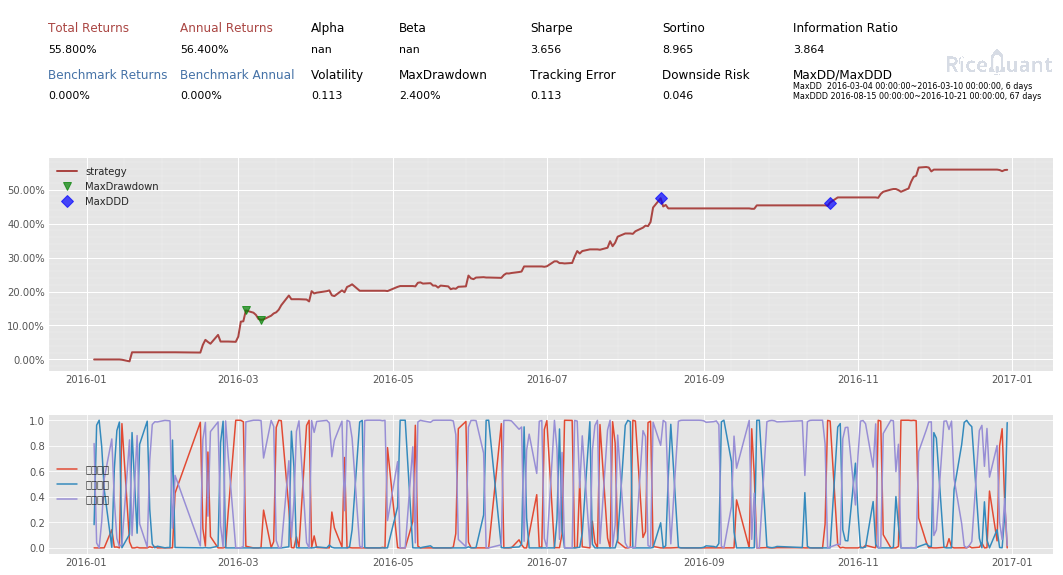

In [28]:
start_date = '2016-01-01'
end_date = '2017-01-01'
accounts = {'stock':1e5}

config = {
    'base':{'start_date':start_date, 'end_date':end_date, 'accounts':accounts},
    'extra':{'log_level':'info'},
    'mod':{'sys_analyser':{'enabled':True, 'plot':True}}
}

results = run_func(init=init, handle_bar=handle_bar, config=config)

2017-01-03 INFO 0
2017-01-03 INFO 沽空
2017-01-03 WARN 订单创建失败: 下单量为0。
2017-01-04 INFO 0
2017-01-04 INFO 沽空
2017-01-04 WARN 订单创建失败: 下单量为0。
2017-01-05 INFO 0
2017-01-05 INFO 沽空
2017-01-05 WARN 订单创建失败: 下单量为0。
2017-01-06 INFO 1
2017-01-09 INFO 1
2017-01-10 INFO 1
2017-01-11 INFO 1
2017-01-12 INFO 1
2017-01-13 INFO 0
2017-01-13 INFO 沽空
2017-01-13 WARN 订单创建失败: 下单量为0。
2017-01-16 INFO 1
2017-01-17 INFO 0
2017-01-17 INFO 沽空
2017-01-17 WARN 订单创建失败: 下单量为0。
2017-01-18 INFO 0
2017-01-18 INFO 沽空
2017-01-18 WARN 订单创建失败: 下单量为0。
2017-01-19 INFO 0
2017-01-19 INFO 沽空
2017-01-19 WARN 订单创建失败: 下单量为0。
2017-01-20 INFO 0
2017-01-20 INFO 沽空
2017-01-20 WARN 订单创建失败: 下单量为0。
2017-01-23 INFO 0
2017-01-23 INFO 沽空
2017-01-23 WARN 订单创建失败: 下单量为0。
2017-01-24 INFO 0
2017-01-24 INFO 沽空
2017-01-24 WARN 订单创建失败: 下单量为0。
2017-01-25 INFO 0
2017-01-25 INFO 沽空
2017-01-25 WARN 订单创建失败: 下单量为0。
2017-01-26 INFO 0
2017-01-26 INFO 沽空
2017-01-26 WARN 订单创建失败: 下单量为0。
2017-02-03 INFO 1
2017-02-06 INFO 1
2017-02-07 INFO 1
2017-02-08 INFO 2
2017

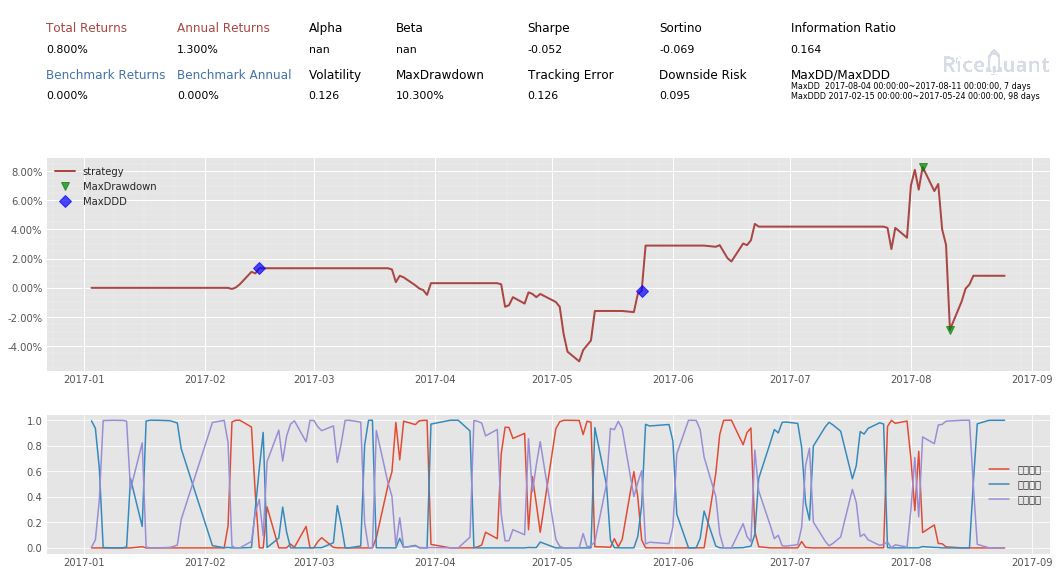

In [29]:
start_date = '2017-01-01'
end_date = '2017-8-27'
accounts = {'stock':1e5}

config = {
    'base':{'start_date':start_date, 'end_date':end_date, 'accounts':accounts},
    'extra':{'log_level':'info'},
    'mod':{'sys_analyser':{'enabled':True, 'plot':True}}
}

results = run_func(init=init, handle_bar=handle_bar, config=config)